<a href="https://colab.research.google.com/github/makhijakabir/machine-learning/blob/main/bayesClassifierESF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#An Email Spam Filter using the Baye's Classifier

##Imports

In [64]:
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

##Constants (All the constant file paths)

In [65]:
exampleFile = '/content/drive/MyDrive/Colab Notebooks/SpamData/01_Processing/practice_email.txt'

spam1 = '/content/drive/MyDrive/Colab Notebooks/SpamData/01_Processing/spam_assassin_corpus/spam_1'
spam2 = '/content/drive/MyDrive/Colab Notebooks/SpamData/01_Processing/spam_assassin_corpus/spam_2'

notSpam1 = '/content/drive/MyDrive/Colab Notebooks/SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
notSpam2 = '/content/drive/MyDrive/Colab Notebooks/SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

spam = 0
notSpam = 1

dataJSON = '/content/drive/MyDrive/Colab Notebooks/SpamData/01_Processing/exmail-test-data.json'

##Reading Files

In [66]:
#Prints the complete file with all the information

stream = open(exampleFile, encoding='latin-1')
message = stream.read()
stream.close()

print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [67]:
 #Prints only the body of the emails

isBody = False
mainList = []

stream = open(exampleFile, encoding='latin-1')

for line in stream:
    if isBody:
        mainList.append(line)
    elif line == '\n':
        isBody = True

stream.close()

finalBody = '\n'.join(mainList)
print(finalBody)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

##Extraction of all the EMail Bodies using generator functions

In [68]:
def emailBodyGen(path):

    for root, dirname, filenames in walk(path):
        for fileName in filenames:

            filepath = join(root, fileName)

            stream = open(filepath, encoding='latin-1')

            isBody = False
            mainList = []

            for line in stream:
                if isBody:
                    mainList.append(line)
                elif line == '\n':
                    isBody = True

            stream.close()

            finalBody = '\n'.join(mainList)
            
            yield fileName, finalBody

In [69]:
def dfFromDir(path, classify):
    
    rows = []
    rowNames = []

    for fileName, finalBody in emailBodyGen(path):
        rows.append({'CATEGORY': classify, 'MESSAGE': finalBody})
        rowNames.append(fileName)

    return pd.DataFrame(rows, index=rowNames) 

In [70]:
#Storing the spam emails in a spamEmails dataframe

spamEmails = dfFromDir(spam1, spam)
spamEmails = spamEmails.append(dfFromDir(spam2, spam))
spamEmails

,CATEGORY,MESSAGE
00273.0c7d73771d79e84e2aab8c909c5bb210,0,This is a multi-part message in MIME format.\n...
00154.b6c448ccff434e2dbe2c7c200a36aa31,0,"On January 1st 2002, the European countries be..."
00223.349b9b0748ee72bad60729ffaae2cc00,0,This is a multi-part message in MIME format.\n...
00351.fd1b8a6cd42e81125fb38c2660cd9317,0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 3.2//E..."
00001.7848dde101aa985090474a91ec93fcf0,0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
...,...,...
00521.70417de823222858b4100b6030a64168,0,BUY 2 ADULT DVDs AT REGULAR PRICE AND GET A TH...
00484.602c7afb217663a43dd5fa24d97d1ca4,0,------=_NextPart_000_0066_62CFF34B.9C652FBA\n\...
00580.c3b23134b4767f5e796d0df997fede33,0,\n\n<html>\n\n\n\n<head>\n\n</head>\n\n\n\n<bo...
00320.a4e760741d537aef50c4c0b950329225,0,<=21DOCTYPE HTML PUBLIC =22-//W3C//DTD HTML 4....


In [71]:
#Storing non spam emails in a notSpaEmails dataframe

notSpamEmails = dfFromDir(notSpam1, notSpam)
notSpamEmails = notSpamEmails.append(dfFromDir(notSpam2, notSpam))
notSpamEmails

,CATEGORY,MESSAGE
01565.c10c0b0e0c9903345e28f9c17fc84400,1,\n\n--iJXiJc/TAIT2rh2r\n\nContent-Type: text/p...
01433.4392b7c4884f0f218e74a0b86cc5b8c3,1,"\n\n""zeek"" said:\n\n\n\n> This was thoroughly ..."
01413.d1561ddcf3ead3a670b4516b3337216c,1,"> > Is the use of ""trusted hardware"" really wo..."
01856.c021a63248e3e6a2e151b67689d75e13,1,URL: http://diveintomark.org/archives/2002/09/...
01498.e0d9701d1bf2798b86efb602a44d072b,1,http://www.hughes-family.org/bugzilla/show_bug...
...,...,...
00695.2de9d6d30a7713e550b4fd02bb35e7b4,1,"""This is a very tenuous time for Microsoft,"" G..."
01137.e0afde7fc471f626742746c738013750,1,On 21 Jul 2002 23:59:59 +1200\n\nMark Derricut...
01294.7f208bf4ae152863fd40f25e2e121d49,1,Pablo Sofware Solutions FTP server Directory T...
00747.352d424267d36975a7b40b85ffd0885e,1,"If you run Pick, and then use the ""New FTOC"" b..."


In [72]:
#Conacatenating the 2 dataframes to create a collusive dataframe for all the values

data = pd.concat([spamEmails, notSpamEmails])
data

,CATEGORY,MESSAGE
00273.0c7d73771d79e84e2aab8c909c5bb210,0,This is a multi-part message in MIME format.\n...
00154.b6c448ccff434e2dbe2c7c200a36aa31,0,"On January 1st 2002, the European countries be..."
00223.349b9b0748ee72bad60729ffaae2cc00,0,This is a multi-part message in MIME format.\n...
00351.fd1b8a6cd42e81125fb38c2660cd9317,0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 3.2//E..."
00001.7848dde101aa985090474a91ec93fcf0,0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
...,...,...
00695.2de9d6d30a7713e550b4fd02bb35e7b4,1,"""This is a very tenuous time for Microsoft,"" G..."
01137.e0afde7fc471f626742746c738013750,1,On 21 Jul 2002 23:59:59 +1200\n\nMark Derricut...
01294.7f208bf4ae152863fd40f25e2e121d49,1,Pablo Sofware Solutions FTP server Directory T...
00747.352d424267d36975a7b40b85ffd0885e,1,"If you run Pick, and then use the ""New FTOC"" b..."


##Data Cleaning and Checking for Missing Values

In [73]:
#Check if there are any missing values
data['MESSAGE'].isnull().values.any() #Returns true if there are any missing values


False

In [74]:
#Check if there are any empty emails with the string length of 0
(data.MESSAGE.str.len() == 0).any()

True

In [75]:
#Check how many entries have the string length of 0
(data.MESSAGE.str.len() == 0).sum()

3

In [76]:
#Getting the index of all the rows where the string length is 0
data[(data.MESSAGE.str.len() == 0)]

,CATEGORY,MESSAGE
cmds,0,
cmds,0,
cmds,1,


##Removinga and Renaming Entries from the Dataset

In [77]:
#cmds is  the ID of the column that refers to the null data

data.drop(['cmds'], inplace=True)

In [78]:
 #Adding Document IDs to track EMail IDs

documentIDs = range(0, len(data.index))
data['DOC_ID'] = documentIDs
data['FILE_NAME'] = data.index
data = data.set_index('DOC_ID')
data

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
0,0,This is a multi-part message in MIME format.\n...,00273.0c7d73771d79e84e2aab8c909c5bb210
1,0,"On January 1st 2002, the European countries be...",00154.b6c448ccff434e2dbe2c7c200a36aa31
2,0,This is a multi-part message in MIME format.\n...,00223.349b9b0748ee72bad60729ffaae2cc00
3,0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 3.2//E...",00351.fd1b8a6cd42e81125fb38c2660cd9317
4,0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",00001.7848dde101aa985090474a91ec93fcf0
...,...,...,...
5791,1,"""This is a very tenuous time for Microsoft,"" G...",00695.2de9d6d30a7713e550b4fd02bb35e7b4
5792,1,On 21 Jul 2002 23:59:59 +1200\n\nMark Derricut...,01137.e0afde7fc471f626742746c738013750
5793,1,Pablo Sofware Solutions FTP server Directory T...,01294.7f208bf4ae152863fd40f25e2e121d49


##Saving the dataframe to the disk

In [79]:
data.to_json(dataJSON)

##Data Visualization through Pie Charts and Donut Charts



In [105]:
spamCounts = data.CATEGORY.value_counts()[0]
notSpamCounts = data.CATEGORY.value_counts()[1]

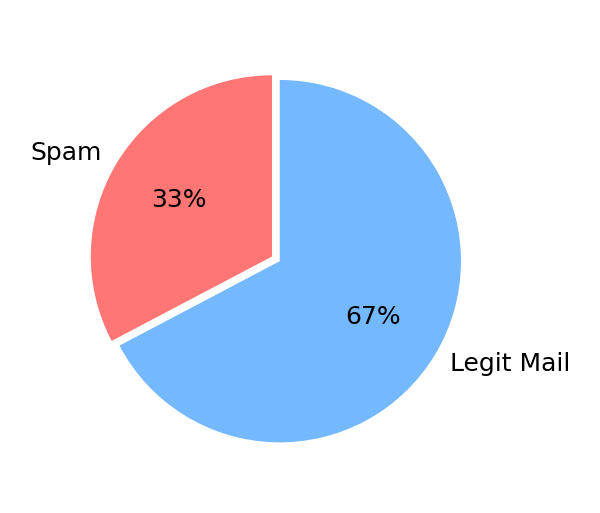

In [106]:
#Creating a pie chart

categoryNames = ['Spam', 'Legit Mail']
size = [spamCounts, notSpamCounts]
colors = ['#ff7675', '#74b9ff']

plt.figure(figsize=(2, 2), dpi=300)
plt.pie(size, labels=categoryNames, textprops={'fontsize': 6}, autopct='%1.0f%%', colors=colors, explode=[0, 0.05], startangle=90)
plt.show()

In [ ]:
#Creating a donut chart

categoryNames = ['Spam', 'Legit Mail']
size = [spamCounts, notSpamCounts]
colors = ['#ff7675', '#74b9ff']

plt.figure(figsize=(2, 2), dpi=300)
plt.pie(size, labels=categoryNames, textprops={'fontsize': 6}, autopct='%1.0f%%', colors=colors, explode=[0, 0.05], startangle=90)
plt.show()